<a href="https://colab.research.google.com/github/michaelthephoenix/Predicting-Horse-Health/blob/main/Predicting_Health_of_Horses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is work from someone on Kaggle link will be included below

It has some cool graphs, seems like guy knows his way around Data Exploration and Analysis so this is me trying to shadow his steps in hopes of learning from his Immortal Technic

[PS S322|EDA (Source Link)](https://www.kaggle.com/code/zhukovoleksiy/ps-s3e22-eda-preprocessing-ensemble)



In [1]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.1 MB/s eta 0:00:00


In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00


In [3]:
# Toolbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import  partial
import gc
import warnings

# Import sklearn classes for model selectio, cross validation, and performance evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from imblearn.under_sampling import RandomUnderSampler

#Importing libraries from Hypertuning
import optuna

#Importing Libraries for Gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels  import RBF
# from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
# from catboost import Pool

for what i thought is a simple task,

i feel like we bringing a whole military armory to kill one guy,

tho
what does the term Ensemble and mean

In [4]:
#Seaborn [pythoon library by aquaman himself])

rc = {
    "axes.facecolor": "#FAEEE9",
    "figure.facecolor": "#FAEEE9",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "arial",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Functions
def print_sl():
  print('=' * 50)
  print()


def show_na(df, column):
  sns.countplot(x='outcome', data=df[df[column].isnull()])
  plt.show()

# Basically more fancy tools i think

Load Data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

print('Data Loaded Succesfully!')
print_sl()

print(f'train shape: {train.shape}')
print(f'are there any null values in train: {train.isnull().any().any()}\n')

print(f'test shape: {test.shape}')
print(f'are there any null values in test: {test.isnull().any().any()}\n')

categorical_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time',
                   'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
                   'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']

num_cols = ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
           'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']

target = 'outcome'
train.head()

Data Loaded Succesfully!

train shape: (1235, 28)
are there any null values in train: False

test shape: (824, 27)
are there any null values in test: False



,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,None,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


Target Distribution

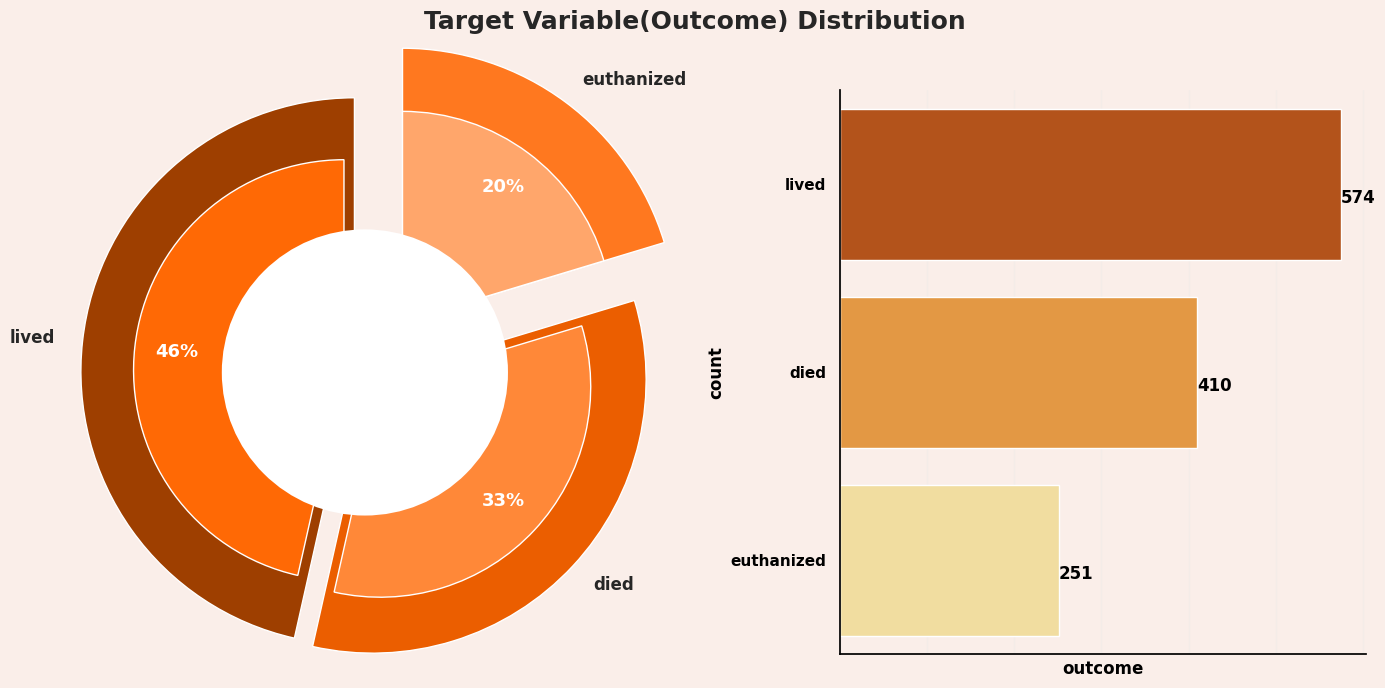

In [6]:
# https://www.kaggle.com/code/kimtaehun/eda-and-baseline-with-multiple-models

def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
  # Set background color
  f, ax = plt.subplots(1,2, figsize=(14, 7))
  plt.subplots_adjust(wspace = 0.2)

  s1 = df[col].value_counts()
  N = len(s1)

  outer_sizes = s1
  inner_sizes = s1/N

  outer_colors = ['#9E3F00', '#eb5e00', '#ff781f']
  inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

  ax[0].pie(
      outer_sizes, colors = outer_colors,
      labels=s1.index.tolist(),
      startangle=90, frame=True, radius= 1.3,
      explode= ([0.05]*(N-1) + [.3]),
      wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
      textprops= {'fontsize': 12, 'weight': 'bold'}
  )

  textprops = {
      'size': 13,
      'weight': 'bold',
      'color': 'white'
  }

  ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )
  center_circle = plt.Circle((0,0), .68, color='black', fc='white', linewidth=0)
  ax[0].add_artist(center_circle)


  x = s1
  y = s1.index.tolist()
  sns.barplot(x=x, y=y, ax=ax[1],palette='YlOrBr_r', orient='horizontal')

  ax[1].spines['top'].set_visible(False)
  ax[1].spines['right'].set_visible(False)
  ax[1].tick_params(
        axis='x',
        which='both',
        bottom=False,
        labelbottom=False
    )
  for i, v in enumerate(s1):
    ax[1].text(v, i+0.1, str(v), color='black', fontweight='bold', fontsize=12)

  plt.setp(ax[1].get_yticklabels(), fontweight="bold")
  plt.setp(ax[1].get_xticklabels(), fontweight="bold")
  ax[1].set_xlabel(col, fontweight="bold", color='black')
  ax[1].set_ylabel('count', fontweight="bold", color='black')

  f.suptitle(f'{title_name}', fontsize=18, fontweight='bold')
  plt.tight_layout()
  plt.show()

plot_count(train, 'outcome', 'Target Variable(Outcome) Distribution')


there is no way we wrote all that code for a fancy pie chart 🤦

# Category Variables

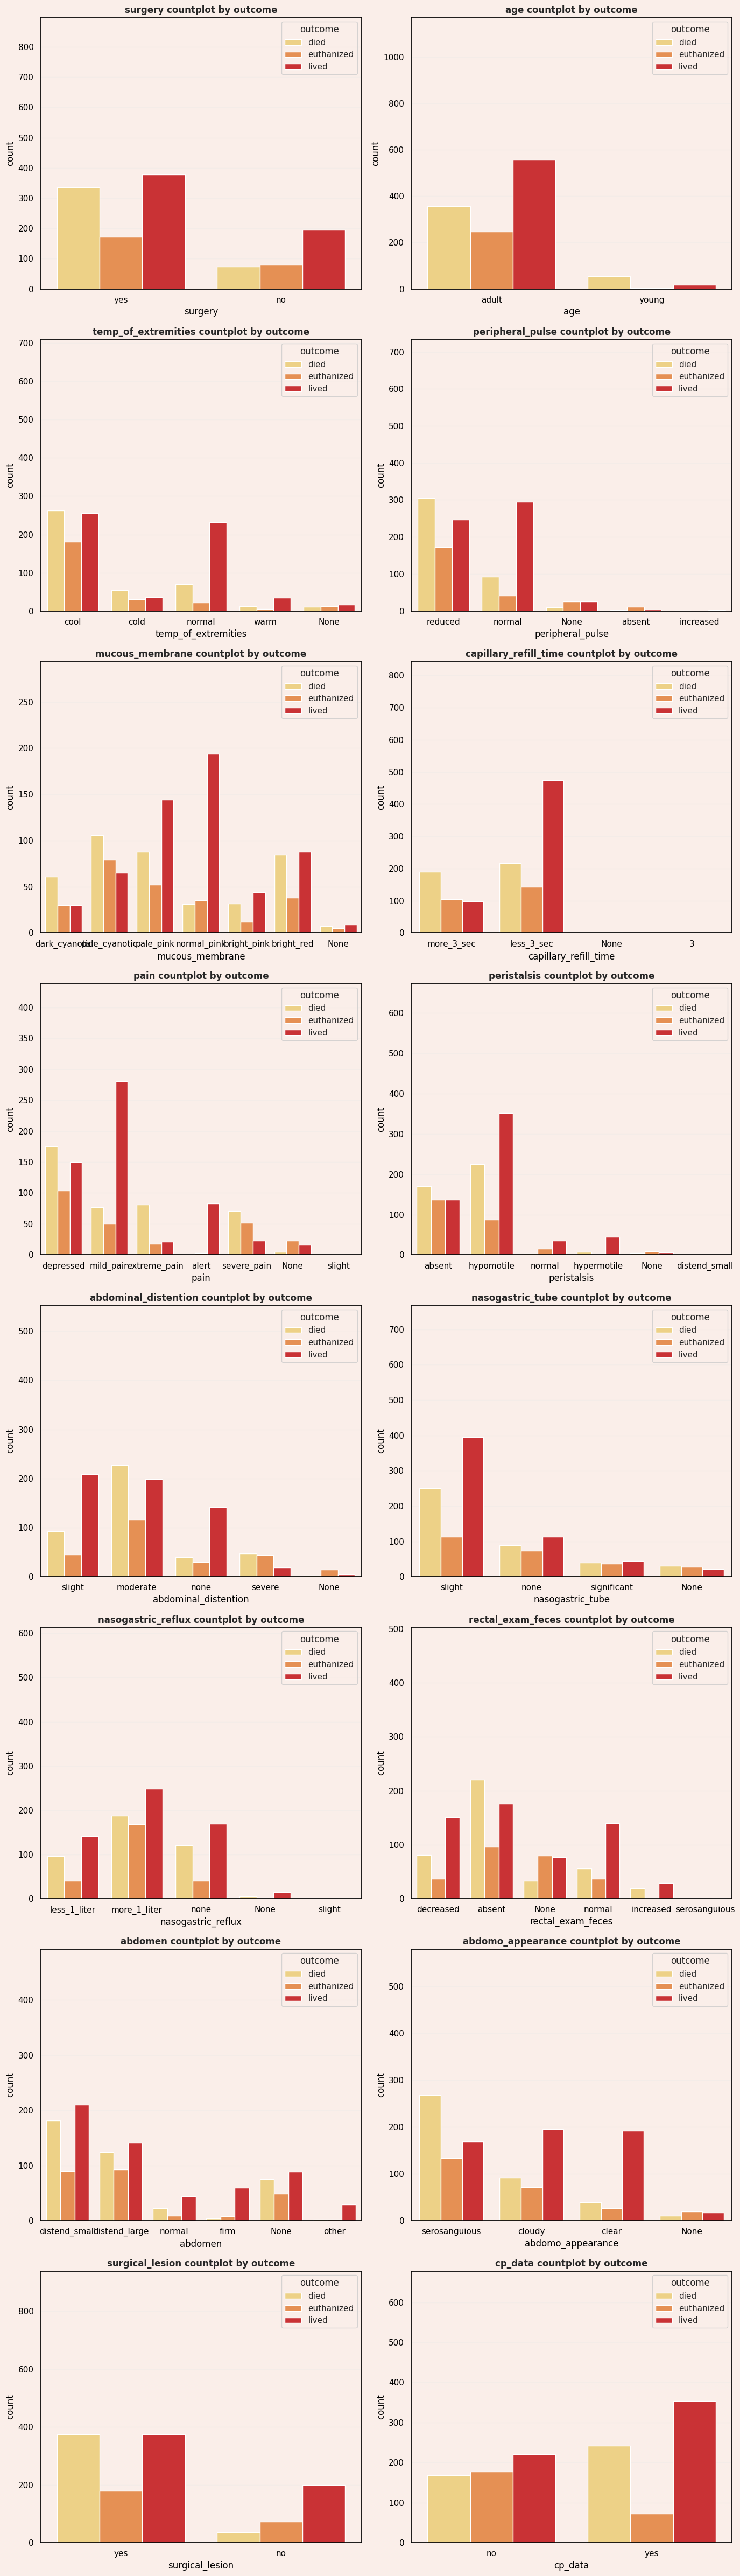

In [7]:
from pandas.core.groupby import categorical
plt.figure(figsize=(14, len(categorical_cols)*3))

for i, col in enumerate(categorical_cols):

  plt.subplot(len(categorical_cols)//2 + len(categorical_cols)%2, 2, i+1)
  sns.countplot(x=col, hue= 'outcome', data=train, palette='YlOrRd')
  plt.title(f'{col} countplot by outcome', fontweight = 'bold')
  plt.ylim(0, train[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()

# Numerical Variables

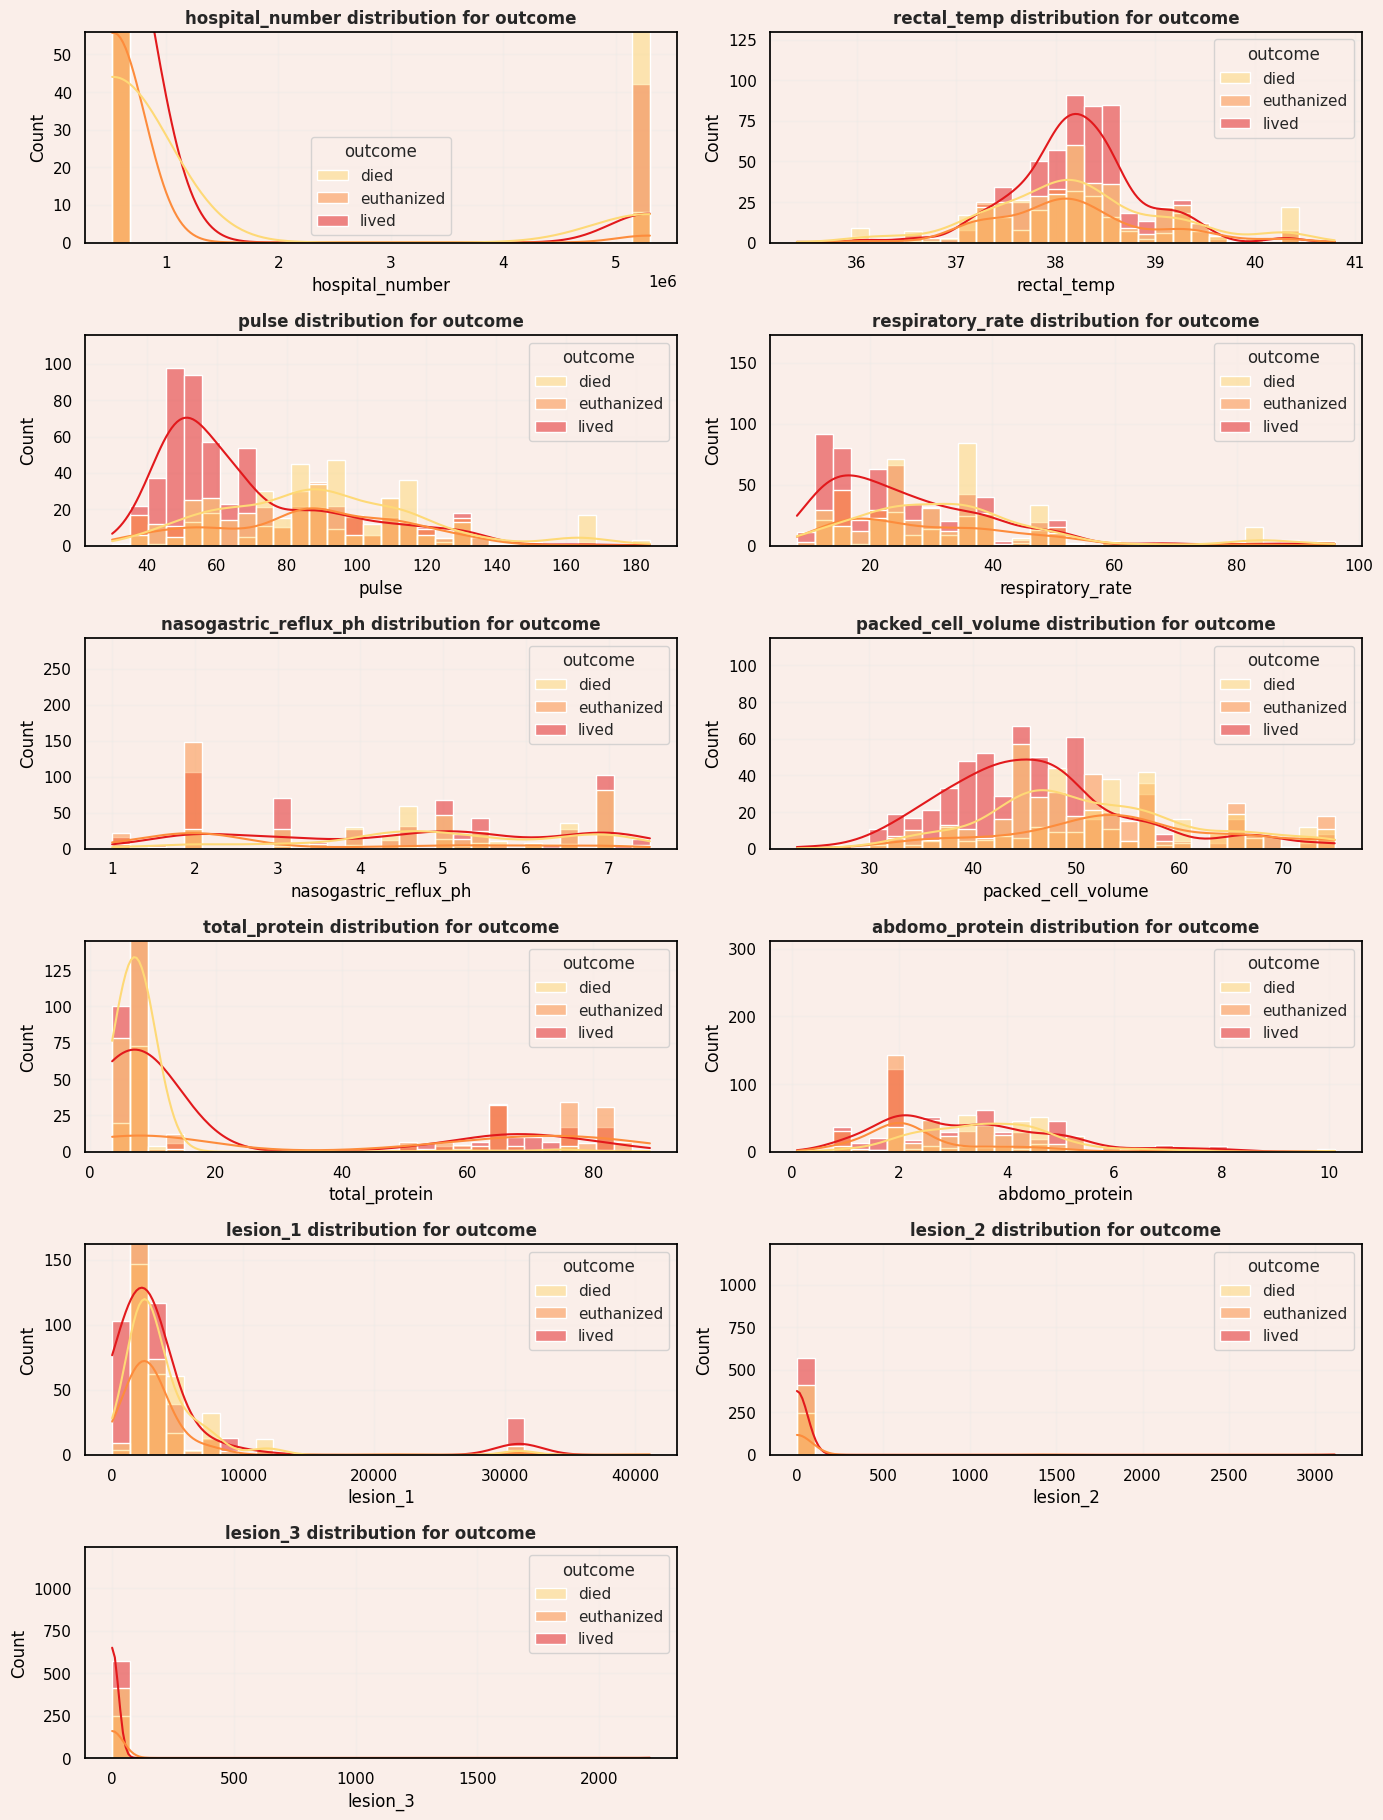

In [8]:
plt.figure(figsize=(14, len(num_cols)*3))

for i, col in enumerate(num_cols):
  # Plotting for outcome
  plt.subplot(len(num_cols), 2, i+1)
  sns.histplot(x=col, hue='outcome', data=train, bins=30, kde=True, palette='YlOrRd')
  plt.title(f'{col} distribution for outcome', fontweight='bold')
  plt.ylim(0, train[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()



# Scatter Matrix

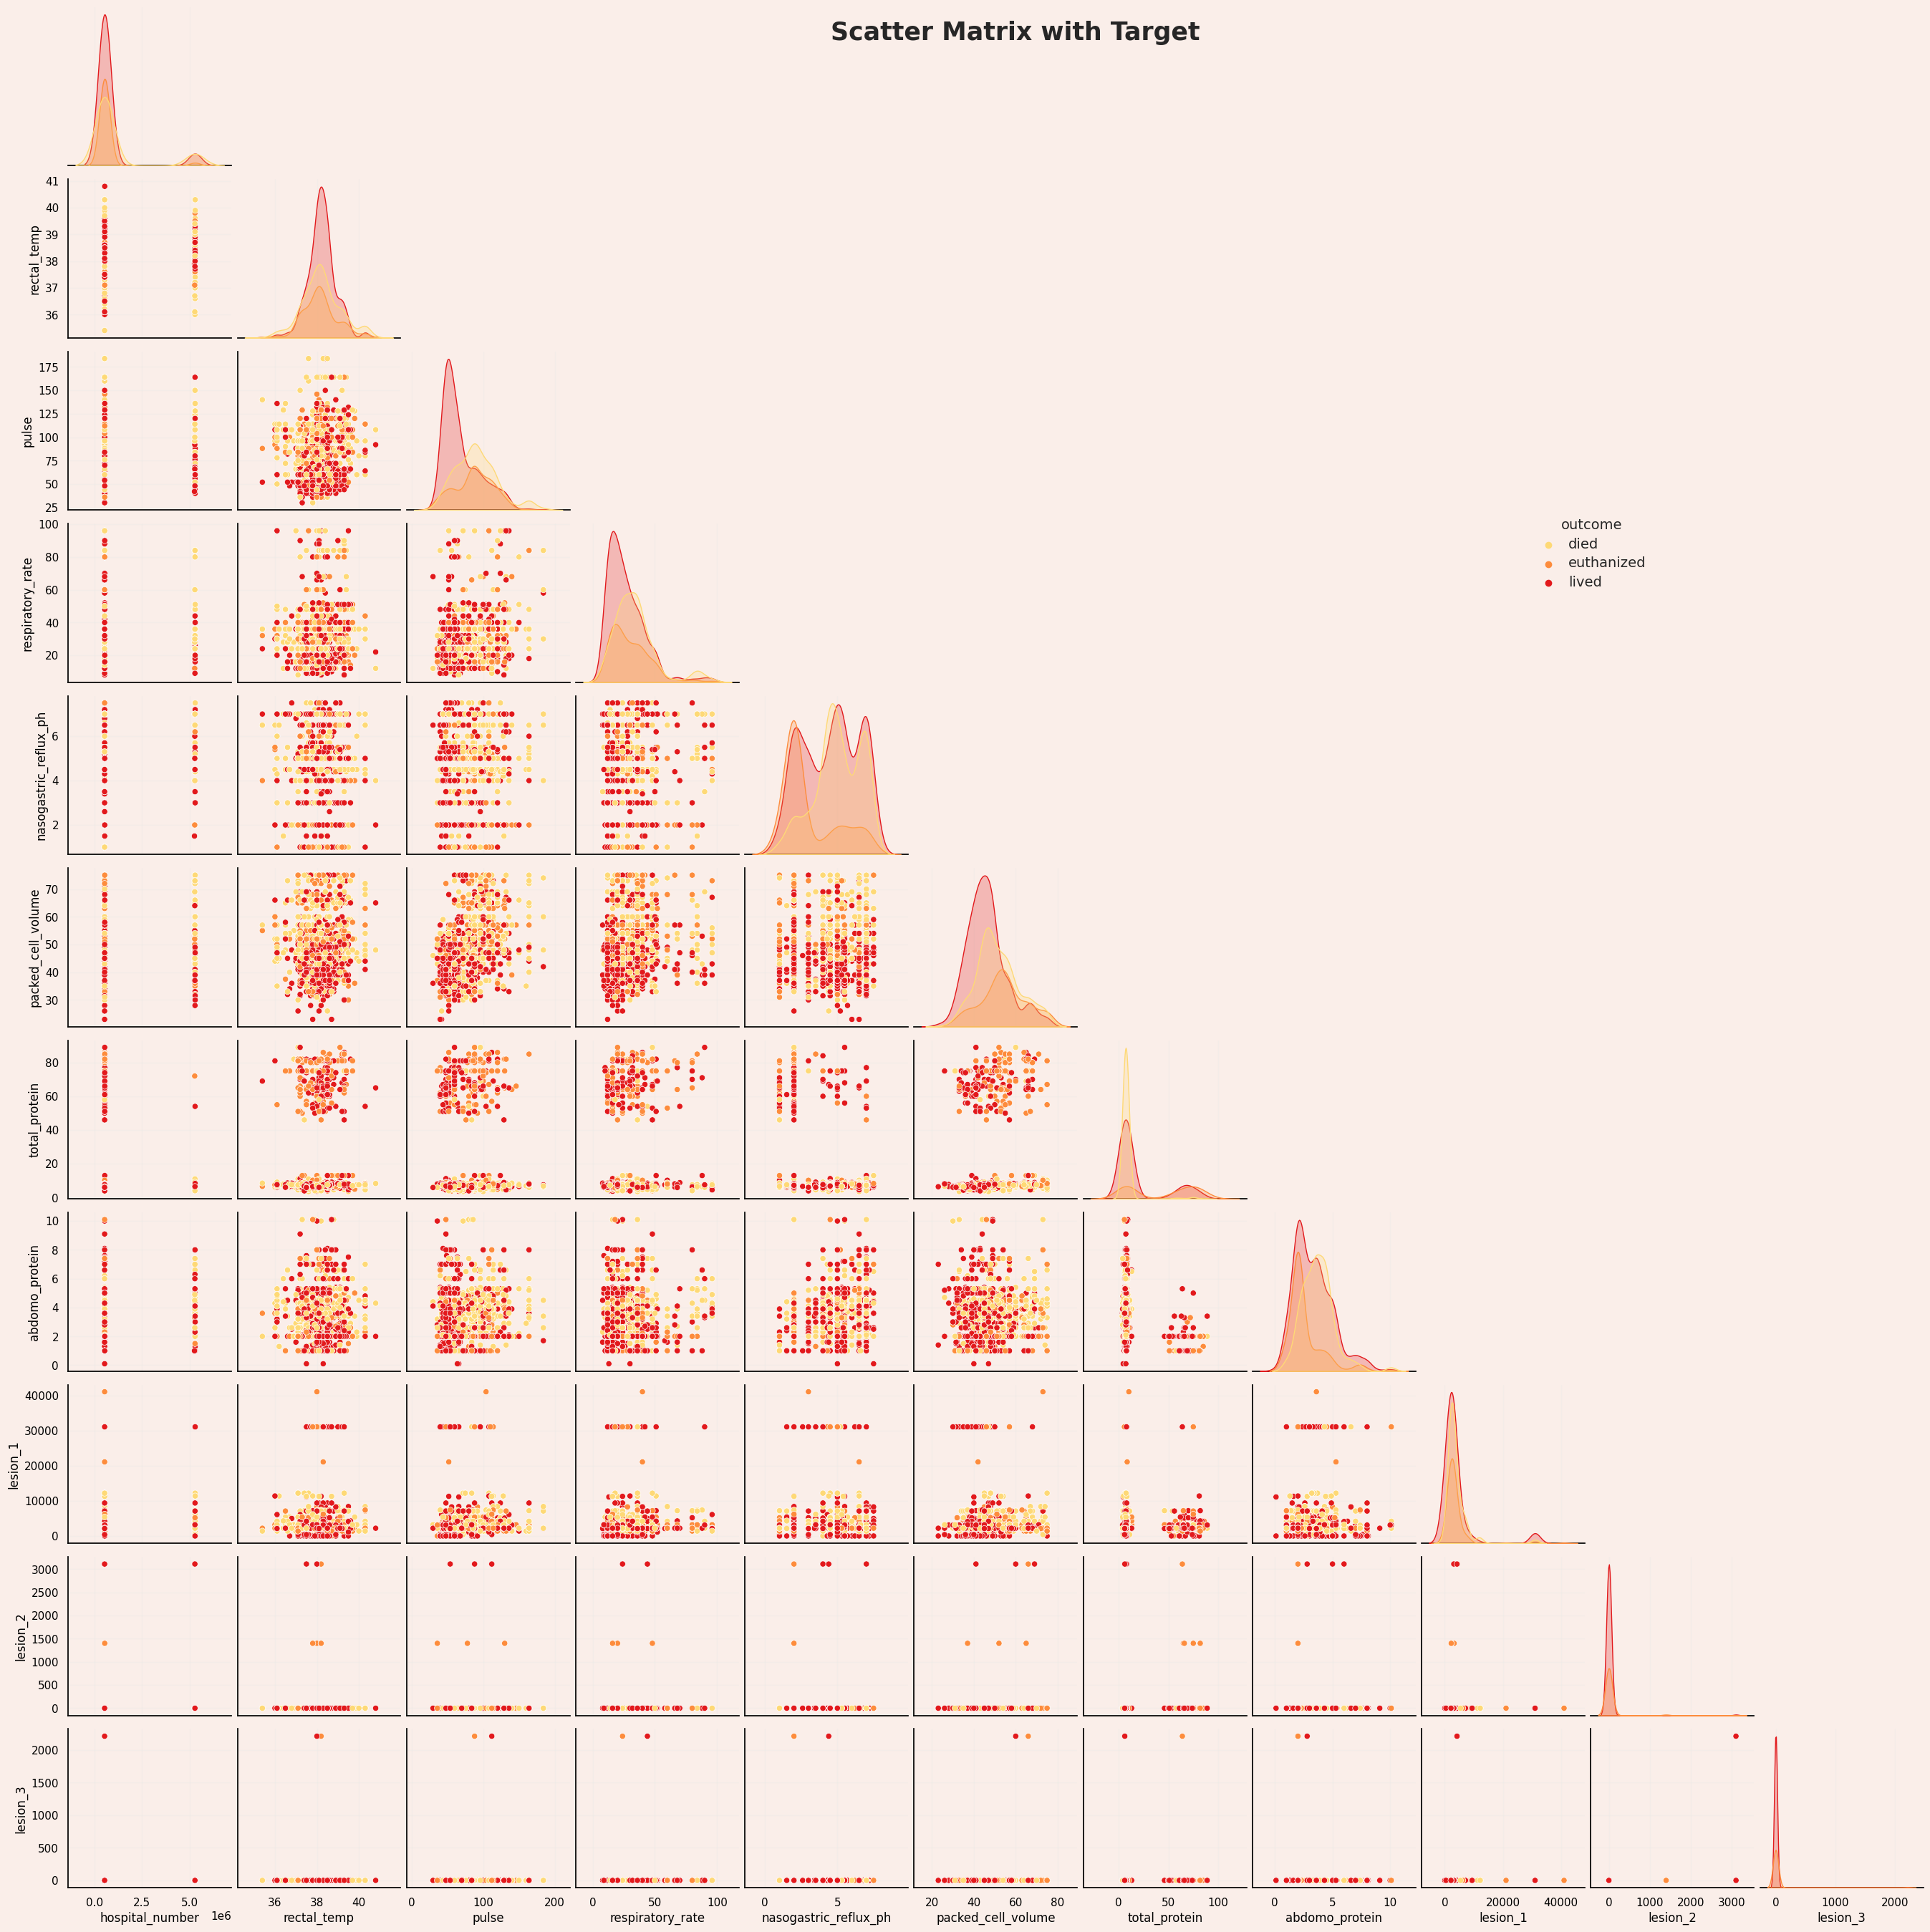

In [9]:
# https://www.kaggle.com/code/yaaangzhou/playground-s3-e22-eda-modeling/notebook

def plot_pair(df_train, num_var, target, plotname):
  '''
  Function to make a pairplot:
  df_train: total data
  num_var: a list of numeric variable
  target: target variable
  '''

  g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True, palette='YlOrRd')
  g._legend.set_bbox_to_anchor((0.8, 0.7))
  g._legend.set_title(target)
  g._legend.loc = 'upper left'
  g._legend.get_title().set_fontsize(14)
  for item in g._legend.get_texts():
    item.set_fontsize(14)

  plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
  plt.show()

plot_pair(train, num_cols, target, plotname= 'Scatter Matrix with Target')

Correlation Heatmap

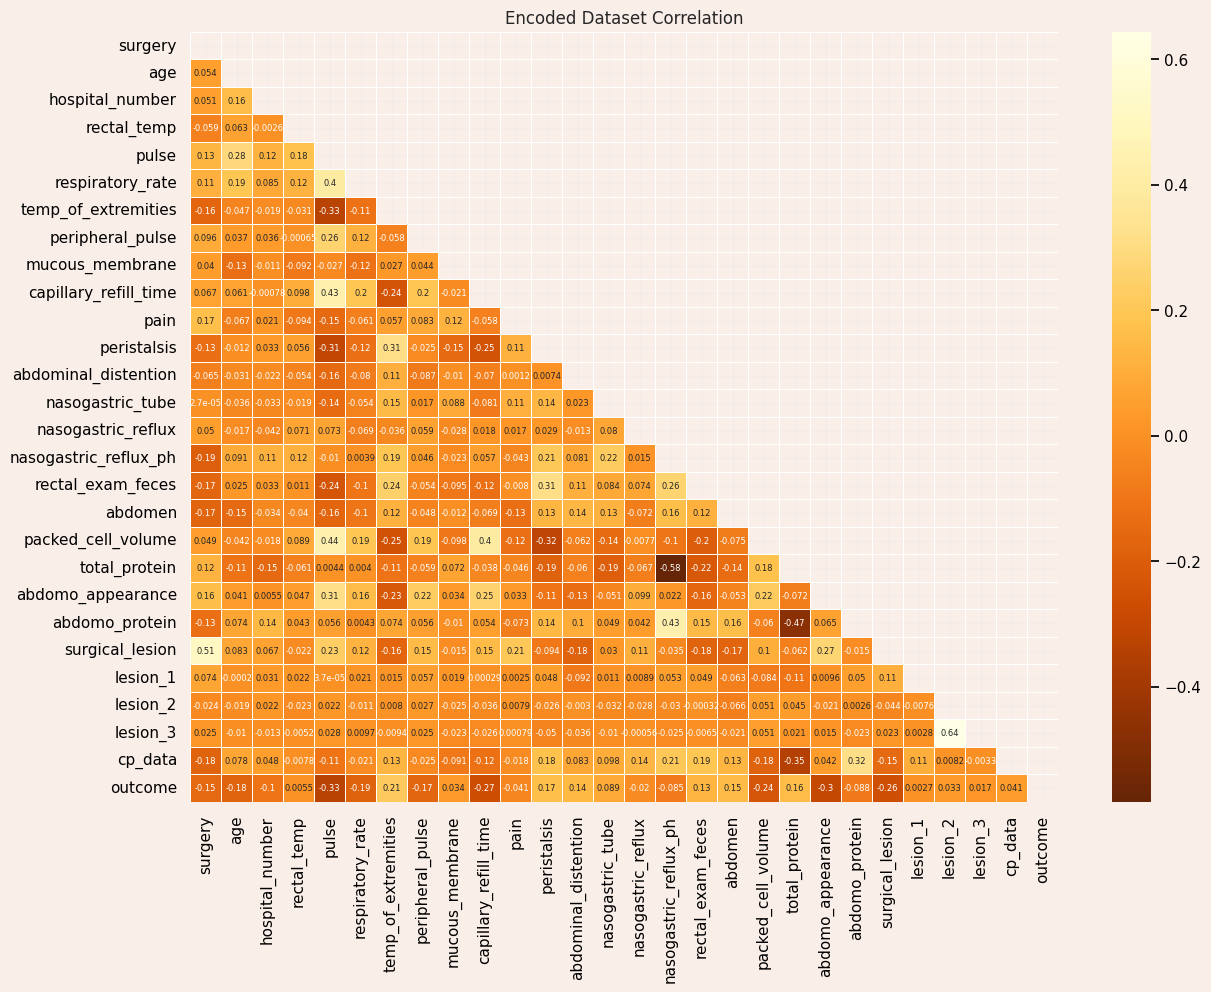

In [10]:
# Create a copy of the dataframe
df_encoded = train.copy()

# Assuming these are your categorical variables, including 'outcome'

categorical_vars = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
                    'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
                    'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
                    'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
                    'cp_data', 'outcome']

#Label encode categorical columns
label_encoders = {}
for column in categorical_vars:
  le = LabelEncoder()
  df_encoded[column] = le.fit_transform(train[column])
  label_encoders[column] = le

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
  excluded_columns = ['id']
  columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
  corr = df[columns_without_excluded].corr()

  fig, axes = plt.subplots(figsize=(14, 10))
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True, annot_kws={'size': 6})
  plt.title(title_name)
  plt.show()

#Plot correlation heatmap for encoded dataframe
plot_correlation_heatmap(df_encoded, 'Encoded Dataset Correlation')

Data Cleaning

In [12]:
def preprocessing(df, le_cols, ohe_cols):

    le = LabelEncoder()

    for col in le_cols:
        df[col] = le.fit_transform(df[col])

    df = pd.get_dummies(df, columns = ohe_cols)

    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')

    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
    df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
    df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
    df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
    df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})

    df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
    df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4})
    df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})

    df.drop('lesion_3',axis=1,inplace=True)

    return df

  def features_engineering(df)


IndentationError: ignored